# Notebook for `dockerDDM`

Author: Hu Chuan-Peng (PhD) @Nanjing Normal University
E-mail: hcp4715@hotmail.com


This is a supplementary notebook for the introductary paper *Reproducible Bayesian hierarchical drift-diffusion modelling with docker*. 

In this notebook, we will demostrate how to conduct HDDM analysis with docker image [`hcp4715/hddm:0.8_tutorial`](https://hub.docker.com/r/hcp4715/hddm/tags).

## Loading modules/packages

In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv, sys
import datetime
from datetime import date
import glob
import feather  # for compiling files

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


The current HDDM version is:  0.8.0
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.11.4


####  Import func for converting HDDM objects to `InferenceData`

The scripts are stored at the `scripts` folder, which need to be added to the path temporarily.

In [2]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = os.path.join(os.path.dirname(os.getcwd()), 'scripts')
scripts_dir = '/home/jovyan/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from plot_ppc_by_cond import plot_ppc_by_cond

#### Load the example data Cavanaght et al. (2011)

In [3]:
data_cavanagh = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')
data_cavanagh.tail()

,subj_idx,stim,rt,response,theta,dbs,conf
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC
3987,13,WW,1.250,1.0,0.752388,0,HC


In [4]:
data_cavanagh.shape

(3988, 7)

## Model fitting

Here we will fit the data with several models. 

### Define model functions for parallel processing

Here we defined six models, from the simplest DDM to full DDM to regression models.

`ms0`: The simplest model, which do not take account of any variable and fit the data with simple DDM (4 parameters only), and with a hierarchical structure.

`ms1`: The second simplest model, which do not take account of any variable, but fit the data with a full DDM (7 parameters), with a hierarchical structure.

In [5]:
%%time

# M0_0: base model: simplified
def ms0(id, df=None, samples=None, burn=None, thin=1, save_name="ms0"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df)
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

# M1: base model: full model
def ms1(id, df=None, samples=None, burn=None, thin=1, save_name="ms1"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'sz', 'st'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

# M2: treat within-subj as between-subj: full model
def ms2(id, df=None, samples=None, burn=None, thin=1, save_name="ms2"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'st', 'sz'], 
                  depends_on={'v': 'conf'})
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m


# M3: regression model (varying intercept)
def ms3(id, df=None, samples=None, burn=None, thin=1, save_name="ms3"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,  
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=True,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

# M4: regression model (varying intercept and slope)
def ms4(id, df=None, samples=None, burn=None, thin = 1, save_name="ms4"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.3 µs


### Work with a single model

Here we can work with only one model.

`HDDMarviz` will save the model objects and the InferenceData separately. The name of model object will be `'function name' + '_' + savetag + chain`, e.g., `ms0_tmp_chain_0`. The file name of the Inference data will be `'function name' + '_' + savetag + '_netcdf'`, e.g., `ms0_tmp_netcdf`

In [6]:
models, InfData = HDDMarviz(data=data_cavanagh, 
                            model_func=ms0,
                            samples=800, 
                            nppc=200, 
                            burn=300, 
                            thin=1, 
                            chains=4, 
                            savefile=True,
                            savetag="tmp")

Inference data  ms0_tmp  already exist, will load model data instead of re-run
current loading:  ms0_tmp_chain_0 

current loading:  ms0_tmp_chain_1 

current loading:  ms0_tmp_chain_2 

current loading:  ms0_tmp_chain_3 



Plot the trace of the model

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_std'}>,
        <AxesSubplot:title={'center':'a_std'}>],
       [<AxesSubplot:title={'center':'a_subj.0'}>,
        <AxesSubplot:title={'center':'a_subj.0'}>],
       [<AxesSubplot:title={'center':'a_subj.1'}>,
        <AxesSubplot:title={'center':'a_subj.1'}>],
       [<AxesSubplot:title={'center':'a_subj.2'}>,
        <AxesSubplot:title={'center':'a_subj.2'}>],
       [<AxesSubplot:title={'center':'a_subj.3'}>,
        <AxesSubplot:title={'center':'a_subj.3'}>],
       [<AxesSubplot:title={'center':'a_subj.4'}>,
        <AxesSubplot:title={'center':'a_subj.4'}>],
       [<AxesSubplot:title={'center':'a_subj.5'}>,
        <AxesSubplot:title={'center':'a_subj.5'}>],
       [<AxesSubplot:title={'center':'a_subj.6'}>,
        <AxesSubplot:title={'center':'a_subj.6'}>],
       [<AxesSubplot:title={'center':'a_subj.7'}>,
        <AxesSubplot:title={'center':'a_su

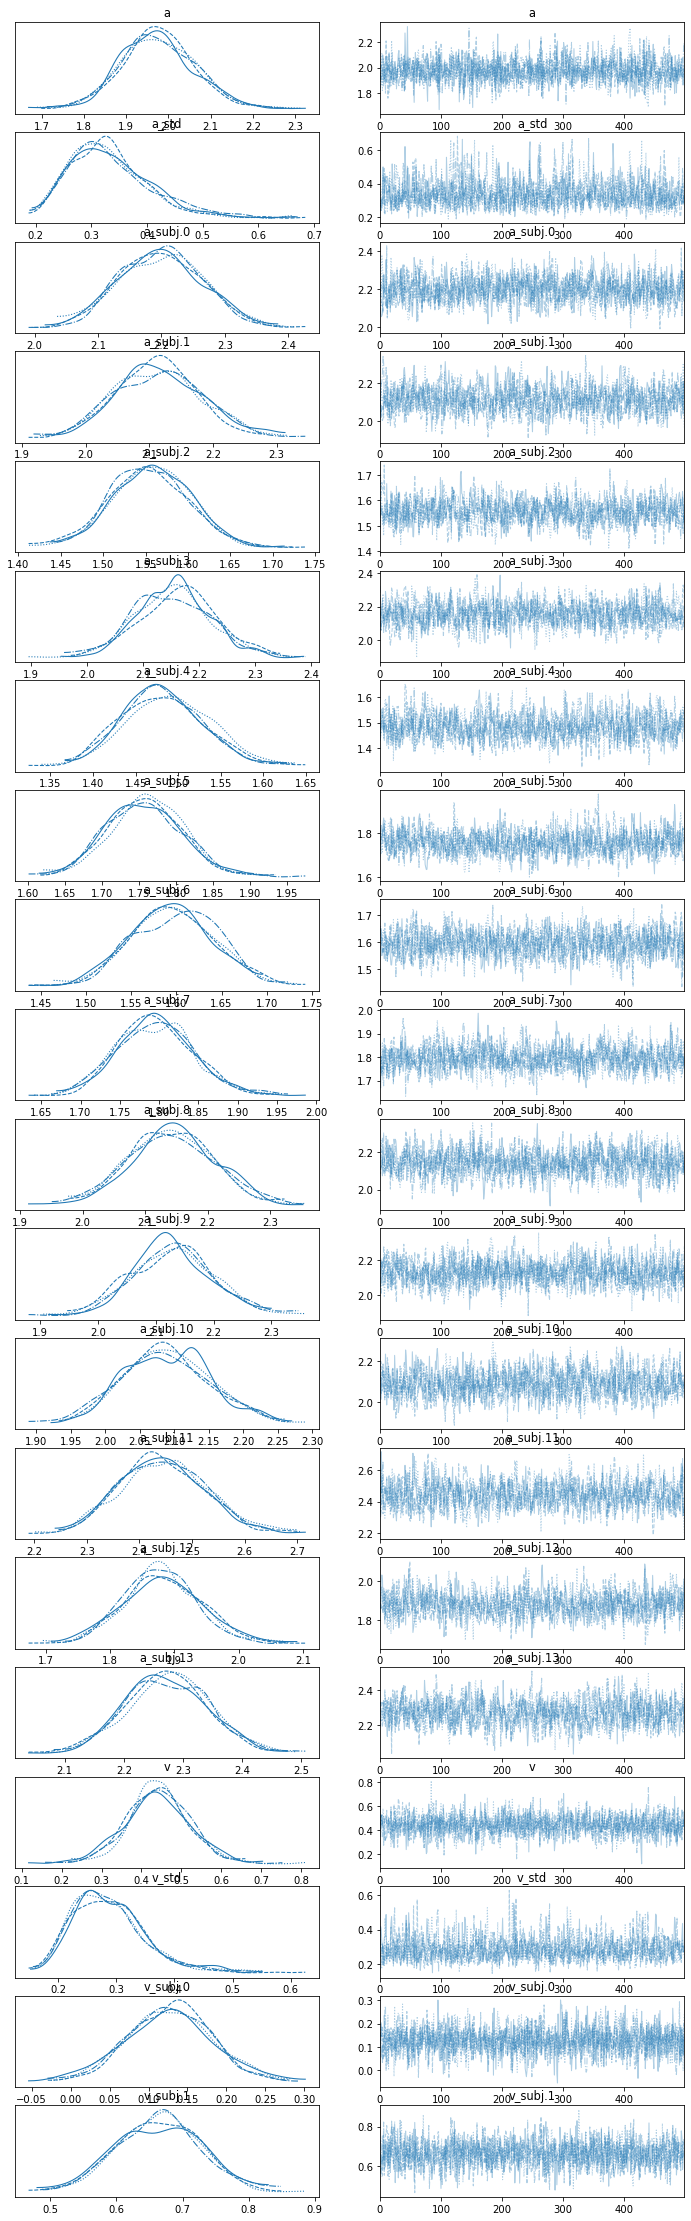

In [7]:
az.plot_trace(InfData)

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

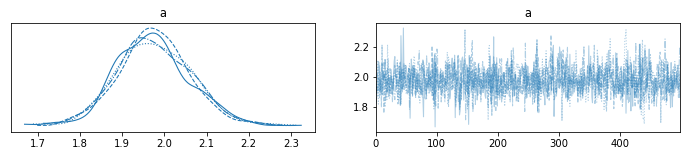

In [8]:
az.plot_trace(InfData, var_names=("^a(?!.*(subj|std))"), filter_vars='regex')

Using `az.summary()` to check $\hat{R}$ and Effective Sample Size (ESS)

In [9]:
ms0_summary = az.summary(InfData)
ms0_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.976,0.091,1.805,2.140,0.002,0.001,1901.0,1553.0,1.00
v_subj.7,0.027,0.069,-0.115,0.144,0.002,0.001,1755.0,1475.0,1.00
v_subj.8,0.492,0.061,0.382,0.607,0.001,0.001,1700.0,1463.0,1.00
v_subj.9,0.226,0.065,0.111,0.354,0.001,0.001,1933.0,1691.0,1.00
v_subj.10,0.570,0.061,0.458,0.684,0.001,0.001,1817.0,1156.0,1.00
v_subj.11,0.590,0.058,0.486,0.707,0.001,0.001,1631.0,1311.0,1.00
v_subj.12,0.613,0.073,0.481,0.752,0.002,0.001,1717.0,1604.0,1.00
v_subj.13,0.217,0.059,0.113,0.326,0.001,0.001,2140.0,1356.0,1.00
t,0.491,0.032,0.431,0.553,0.001,0.001,1398.0,1062.0,1.00
t_std,0.119,0.028,0.076,0.170,0.001,0.001,1100.0,988.0,1.00


Plot the posterior predictives

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

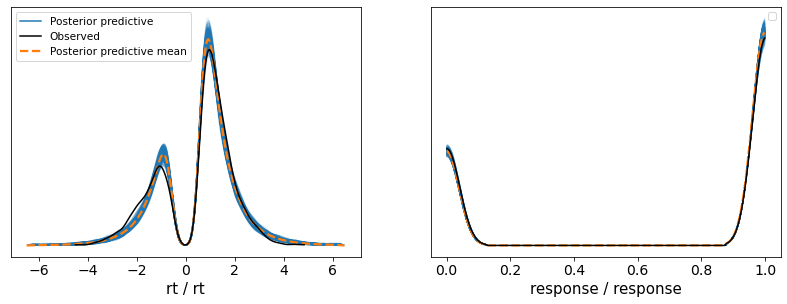

In [10]:
az.plot_ppc(InfData)

In [11]:
az.loo(InfData)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 2000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -10648.47  1572.31
p_loo     5132.19        -

There has been a warning during the calculation. Please check the results.

In [12]:
az.waic(InfData)

Computed from 2000 by 3988 log-likelihood matrix

          Estimate       SE
elpd_waic -38121.68  12326.66
p_waic    32605.40        -

There has been a warning during the calculation. Please check the results.

### Work with multiple models

#### Define arguments for model fitting and converting

Because we are going to compare different models, it's better to make the input arguments the same for all models.

Here, we have a `test_mode` to quickly test the code. If `test_mode` is true, then the samples, burn, number of posterior predictives (nppc) will be relatively small.

In [13]:
test_mode = False

if test_mode:
    samples = 800      # number of MCMC sample; Cavanagh et al.2011 used 30,000
    burn = 300         # number of burn in; Cavanagh et al.2011 used 10,000
    nppc = 200         # number of posterior predictive, super slow
    thin = 1           # thining
    chains = 4         # number of chains, default is 4
    savefile=False     # save file or not, only "True" is available for now.
    savetag = "tmp"    # tag added to saved files.
    model_func = [ms0,
                  ms4] # only test two simple models
else:
    samples = 40000    # number of MCMC sample; Cavanagh et al.2011 used 30,000
    burn = 10000       # number of burn in; Cavanagh et al.2011 used 10,000
    nppc = 5000        # number of posterior predictive, super slow
    thin = 3           # thining
    chains = 4         # number of chains, default is 4
    savefile= True     # save file or not, only "True" is available for now.
    savetag = None     # tag added to saved files.
    model_func = [ms0,
                  ms1,
                  ms2,
                  ms3,
                  ms4]

#### Fit models and convert to Inference data

**Note 1: Here we can run multiple models using python script in terminal. Our experience is that runnign model in terminal is better because jupyter notebook has issue with the progress bar of the parallel processing.**

`python -W ignore Run_all_models.py --samples 40000 --burn 10000 --thin 3 --nppc 5000 --chains 4 --test 0`

`python -W ignore Run_all_models.py --samples 40000 --burn 10000 --thin 3 --nppc 5000 --chains 4 --test 0 --model "ms3"`

**Note 2: Fitting all these six model with settings above (40000 samples, 5000 PPC) takes a few days on a PC with Intel® Core™ i7-10700 CPU @ 2.90GHz. Also, the memory capacity should be large enough, ~ 64 G memory is recommended. Otherwise, we recommend few samples**

In [14]:
%%time
models, InfData = HDDMarviz(data=data_cavanagh, 
                            model_func=model_func,
                            samples=samples, 
                            nppc=nppc, 
                            burn=burn, 
                            thin=thin, 
                            chains=chains, 
                            savefile=savefile,
                            savetag=savetag)

Inference data  ms0  already exist, will load model data instead of re-run
current loading:  ms0_chain_0 

current loading:  ms0_chain_1 

current loading:  ms0_chain_2 

current loading:  ms0_chain_3 

Inference data  ms1  already exist, will load model data instead of re-run
current loading:  ms1_chain_0 

current loading:  ms1_chain_1 

current loading:  ms1_chain_2 

current loading:  ms1_chain_3 

Inference data  ms2  already exist, will load model data instead of re-run
current loading:  ms2_chain_0 

current loading:  ms2_chain_1 

current loading:  ms2_chain_2 

current loading:  ms2_chain_3 

Inference data  ms3  already exist, will load model data instead of re-run
current loading:  ms3_chain_0 

current loading:  ms3_chain_1 

current loading:  ms3_chain_2 

current loading:  ms3_chain_3 

Inference data  ms4  already exist, will load model data instead of re-run
current loading:  ms4_chain_0 

current loading:  ms4_chain_1 

current loading:  ms4_chain_2 

current loading: 

## Bayesian modelling with `ArviZ`

### Model diagnosis

#### Visual inspection

Let's also plot the trace of `ms0`. Using the default settings, it will plot all parameters' trace. We can index each model's InferenceData using name. Here we use the same name as the name of function.

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_std'}>,
        <AxesSubplot:title={'center':'a_std'}>],
       [<AxesSubplot:title={'center':'a_subj.0'}>,
        <AxesSubplot:title={'center':'a_subj.0'}>],
       [<AxesSubplot:title={'center':'a_subj.1'}>,
        <AxesSubplot:title={'center':'a_subj.1'}>],
       [<AxesSubplot:title={'center':'a_subj.2'}>,
        <AxesSubplot:title={'center':'a_subj.2'}>],
       [<AxesSubplot:title={'center':'a_subj.3'}>,
        <AxesSubplot:title={'center':'a_subj.3'}>],
       [<AxesSubplot:title={'center':'a_subj.4'}>,
        <AxesSubplot:title={'center':'a_subj.4'}>],
       [<AxesSubplot:title={'center':'a_subj.5'}>,
        <AxesSubplot:title={'center':'a_subj.5'}>],
       [<AxesSubplot:title={'center':'a_subj.6'}>,
        <AxesSubplot:title={'center':'a_subj.6'}>],
       [<AxesSubplot:title={'center':'a_subj.7'}>,
        <AxesSubplot:title={'center':'a_su

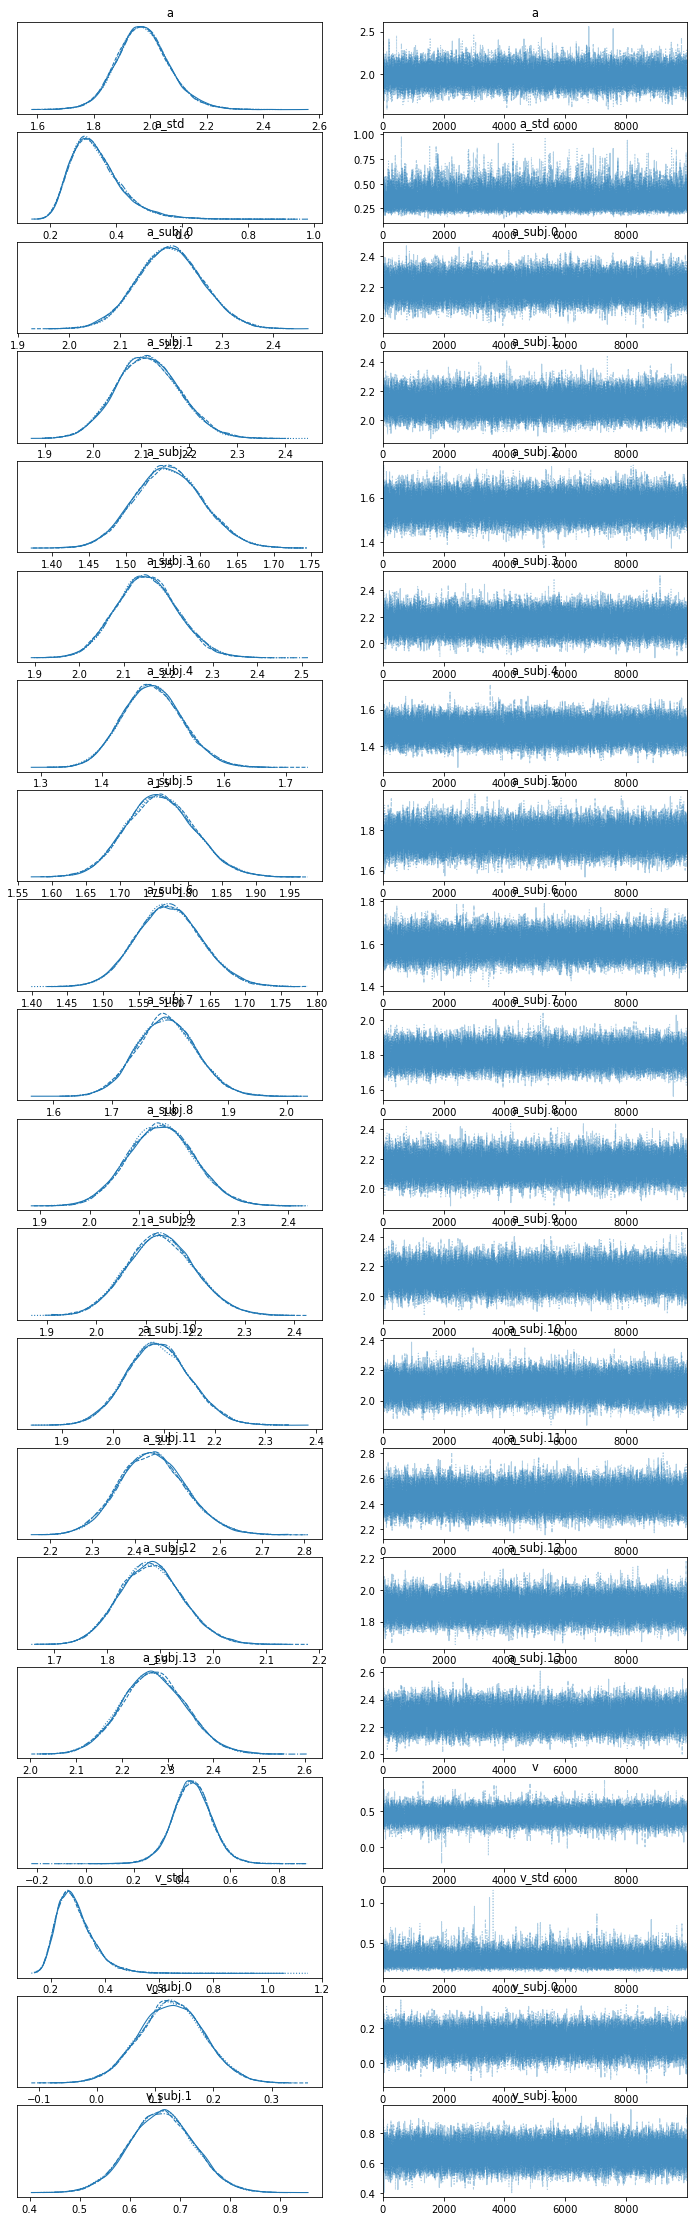

In [15]:
az.plot_trace(InfData['ms0'])

We can also only plot selected parameters' traces. Here we use regex to select var_names that start with "a" and do not contain either "subj" or "std".

array([[<AxesSubplot:title={'center':'sv'}>,
        <AxesSubplot:title={'center':'sv'}>],
       [<AxesSubplot:title={'center':'v_Intercept'}>,
        <AxesSubplot:title={'center':'v_Intercept'}>],
       [<AxesSubplot:title={'center':'v_Intercept_std'}>,
        <AxesSubplot:title={'center':'v_Intercept_std'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.0'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.0'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.1'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.1'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.2'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.2'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.3'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.3'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.4'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.4'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.5'}>,
       

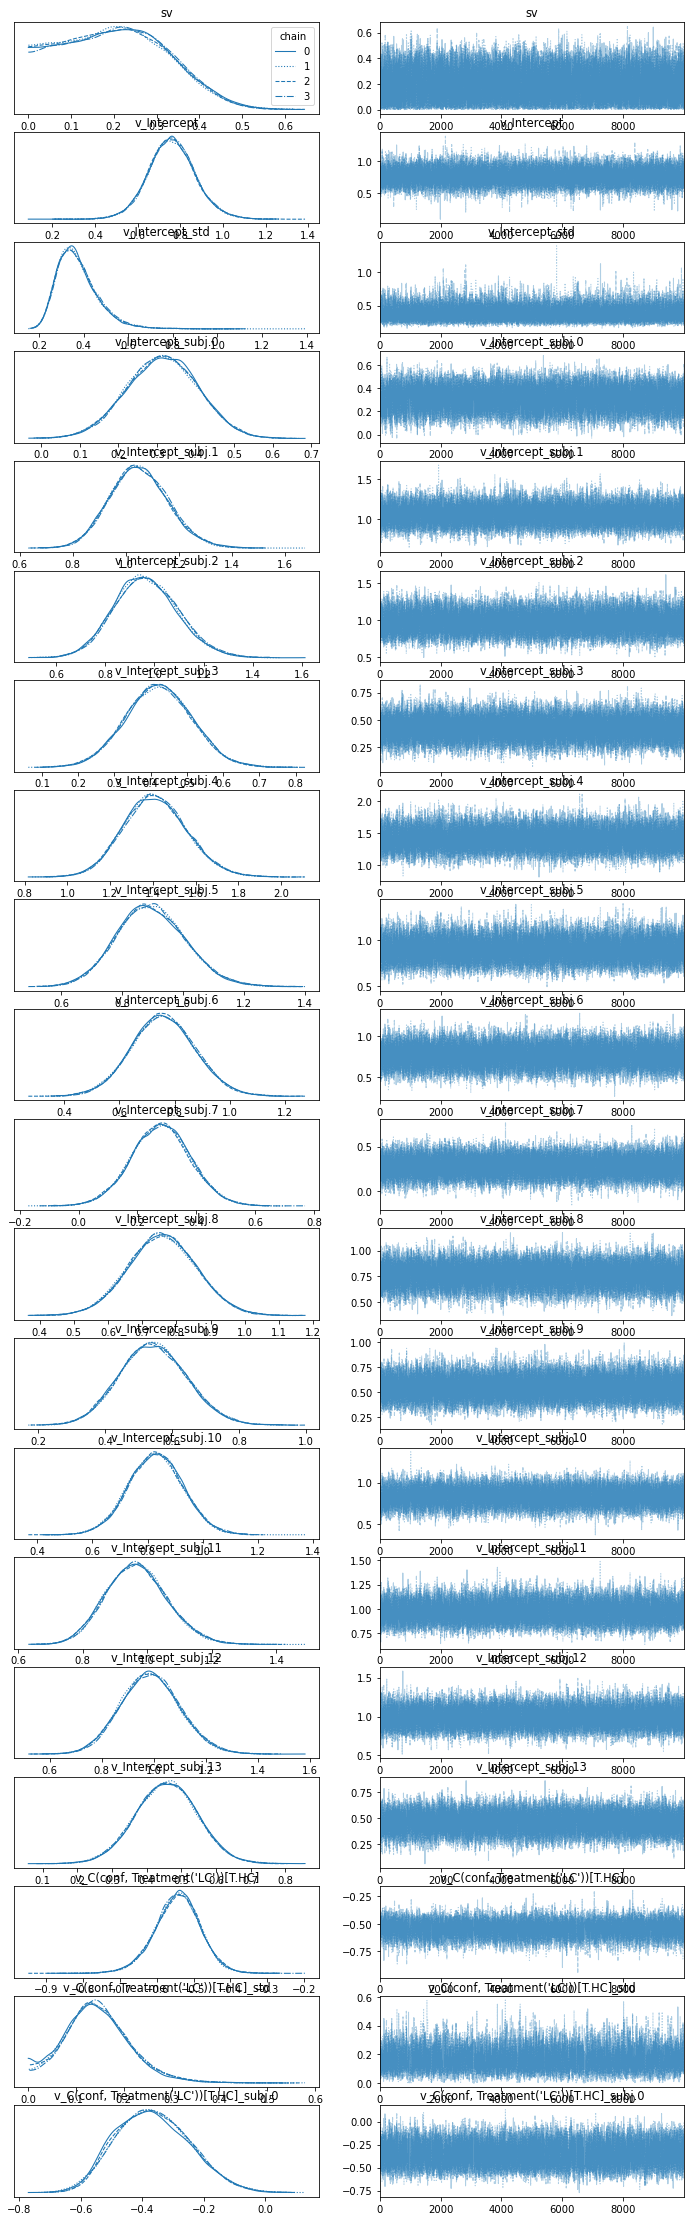

In [16]:
az.plot_trace(InfData['ms4'], var_names= ('v'), filter_vars="like", combined=False, compact=True, legend=True)

array([[<AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>,
        <AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>]],
      dtype=object)

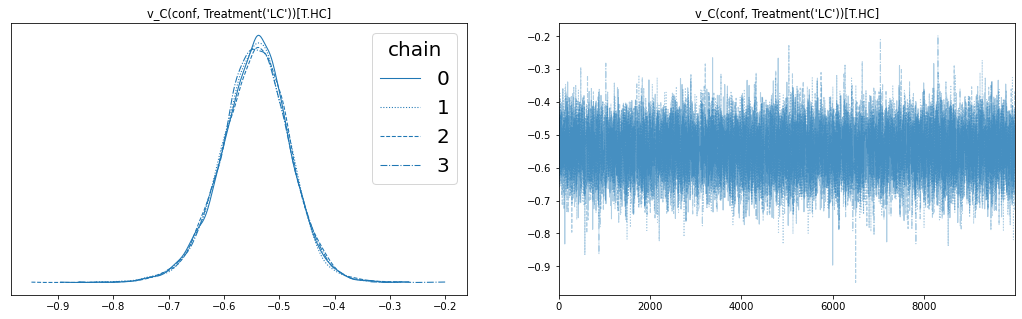

In [17]:
plt.rc('font', size=20)
az.plot_trace(InfData['ms4'], var_names=("^v(?!.*(subj|std|Intercept))"), filter_vars='regex', 
              legend=True, figsize = [18, 5])

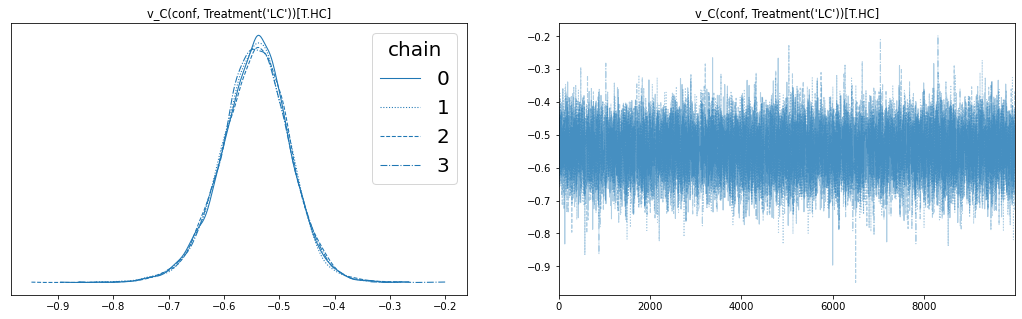

In [18]:
axes = az.plot_trace(InfData['ms4'], var_names=("^v(?!.*(subj|std|Intercept))"), filter_vars='regex', 
                     legend=True, figsize = [18, 5])
fig = axes.ravel()[0].figure
fig.savefig("fig4a.pdf")

#### $\hat{R}$

In [19]:
az.rhat(InfData['ms4'])

<xarray.Dataset>
Dimensions:                                   ()
Data variables: (12/83)
    a                                         float64 1.0
    a_std                                     float64 1.0
    a_subj.0                                  float64 1.0
    a_subj.1                                  float64 1.0
    a_subj.2                                  float64 1.0
    a_subj.3                                  float64 1.0
    ...                                        ...
    v_C(conf, Treatment('LC'))[T.HC]_subj.8   float64 1.0
    v_C(conf, Treatment('LC'))[T.HC]_subj.9   float64 1.0
    v_C(conf, Treatment('LC'))[T.HC]_subj.10  float64 1.0
    v_C(conf, Treatment('LC'))[T.HC]_subj.11  float64 1.001
    v_C(conf, Treatment('LC'))[T.HC]_subj.12  float64 1.0
    v_C(conf, Treatment('LC'))[T.HC]_subj.13  float64 1.0

#### Using `az.summary()` to check $\hat{R}$ and ESS

In [20]:
ms0_summary = az.summary(InfData['ms0'])
ms0_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.976,0.094,1.799,2.154,0.0,0.0,39009.0,36617.0,1.0
v_subj.8,0.494,0.061,0.383,0.612,0.0,0.0,39229.0,39069.0,1.0
v_subj.9,0.227,0.066,0.107,0.356,0.0,0.0,39177.0,37602.0,1.0
v_subj.10,0.571,0.062,0.456,0.691,0.0,0.0,39780.0,37651.0,1.0
v_subj.11,0.590,0.056,0.489,0.700,0.0,0.0,39424.0,39189.0,1.0
v_subj.12,0.615,0.072,0.479,0.750,0.0,0.0,40449.0,39784.0,1.0
v_subj.13,0.217,0.056,0.110,0.322,0.0,0.0,39821.0,39227.0,1.0
t,0.490,0.033,0.429,0.553,0.0,0.0,37337.0,37059.0,1.0
t_std,0.119,0.029,0.072,0.171,0.0,0.0,36462.0,35575.0,1.0
t_subj.0,0.552,0.030,0.496,0.611,0.0,0.0,36490.0,36583.0,1.0


In [21]:
ms4_summary = az.summary(InfData['ms4'])
ms4_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.842,0.108,1.638,2.047,0.001,0.000,33422.0,36548.0,1.0
v_Intercept_subj.6,0.758,0.116,0.539,0.977,0.001,0.001,16108.0,29201.0,1.0
v_Intercept_subj.5,0.896,0.114,0.682,1.109,0.001,0.001,11655.0,24981.0,1.0
v_Intercept_subj.4,1.411,0.149,1.140,1.699,0.001,0.001,14765.0,26416.0,1.0
v_Intercept_subj.3,0.422,0.092,0.242,0.588,0.001,0.000,19135.0,29276.0,1.0
...,...,...,...,...,...,...,...,...,...
t_subj.6,0.539,0.027,0.487,0.589,0.000,0.000,13434.0,19417.0,1.0
t_subj.5,0.502,0.026,0.452,0.551,0.000,0.000,11388.0,18308.0,1.0
t_subj.4,0.469,0.024,0.423,0.516,0.000,0.000,12223.0,21516.0,1.0
t_subj.2,0.601,0.022,0.559,0.642,0.000,0.000,12629.0,21858.0,1.0


### Model comparison and selection

#### DIC

Here we record the DIC of each model in the models and sort by DIC.

In [22]:
%%time

tmp_dic = []
indx_name = []
for m_key, model in models.items():
    m_tmp = kabuki.utils.concat_models(model)
    tmp_dic.append(m_tmp.dic)
    indx_name.append(m_key)
    
comp_dic = pd.DataFrame(tmp_dic, index=indx_name, columns=['dic'])
comp_dic = comp_dic.sort_values(by=['dic'])
comp_dic = comp_dic.reset_index()
comp_dic.rename(columns={'index':'rank'}, inplace=True)
comp_dic

CPU times: user 30.9 s, sys: 344 ms, total: 31.2 s
Wall time: 31.2 s


,rank,dic
0,ms2,10654.827456
1,ms4,10656.368613
2,ms3,10661.306425
3,ms1,10835.371664
4,ms0,10973.378281


#### PSIS-LOO-CV

Warining here is caused by large number as input of `exp()`, solution is [here](https://stackoverflow.com/questions/40726490/overflow-error-in-pythons-numpy-exp-function).

`p_loo`is large than *p*, which is the parameters of the model, which means the model is badly misspecified according to Aki Vehtari's [Q & A](https://avehtari.github.io/modelselection/CV-FAQ.html#18_What_is_the_interpretation_of_p_loo). 

For all models, the *N*, number of obersvations, is 3988, and the number of parameters varies(`ms0` has 48, and `ms5` has 115)

In [23]:
comp_loo = az.compare(InfData, ic='loo')
comp_loo

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ms4,0,-8494.899839,3090.348290,0.000000,3.891388e-01,1342.173079,0.000000,True,log
ms3,1,-8546.133073,3131.958705,51.233233,1.283625e-01,1325.520818,82.050067,True,log
ms2,2,-8779.101168,3380.077606,284.201328,2.889382e-01,1423.458669,167.259631,True,log
ms1,3,-8910.894360,3410.432229,415.994521,3.178741e-12,1402.718798,155.730745,True,log
ms0,4,-14629.016182,9112.557315,6134.116343,1.935605e-01,2250.097651,2483.003942,True,log


####  WAIC

In [24]:
comp_waic = az.compare(InfData, ic='waic')
comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
ms3,0,-11849.019369,6434.845002,0.000000,0.000000,3414.053749,0.000000,True,log
ms4,1,-12225.024785,6820.473236,376.005416,0.592812,3656.875508,267.412629,True,log
ms2,2,-12525.747655,7126.724093,676.728286,0.204882,3640.610693,352.148159,True,log
ms1,3,-12735.338864,7234.876733,886.319494,0.000000,3628.082194,381.811735,True,log
ms0,4,-38979.724247,33463.265380,27130.704878,0.202306,12209.161960,12616.724691,True,log


#### PSIS failed
**Warnings**: Now that we found $\hat{k} >  0.7$, which means importance sampling (PSIS) is not able to provide useful estimate for that component/observation. Highly influential observations have high $\hat{k}$ values. Very high $\hat{k}$ values often indicate model misspecification, outliers or mistakes in data processing.

As we can from below, this was primarily because of a few outliers. As HDDM allow for 5 percent of outliers in modelling, it is not surprising that these outliers stronly influenced the model performance. Here, we remove the outliers from all models and check the results again.

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


<AxesSubplot:title={'center':'ms3 - ms4'}, ylabel='ELPD difference'>

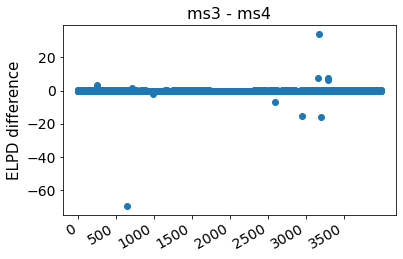

In [25]:
az.plot_elpd({"ms3": InfData['ms3'], "ms4": InfData['ms4']}, xlabels=True)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


<AxesSubplot:xlabel='Data Point', ylabel='Shape parameter k'>

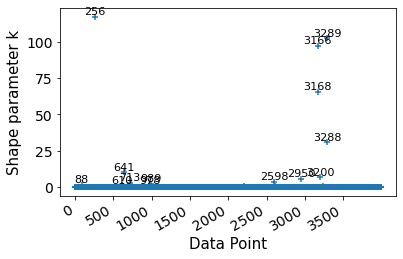

In [26]:
khats = az.loo(InfData['ms4'], pointwise=True).pareto_k

az.plot_khat(khats, xlabels=True, threshold=0.7)

In [27]:
loo_ms0 = az.loo(InfData['ms0'], pointwise=True)
loo_ms1 = az.loo(InfData['ms1'], pointwise=True)
loo_ms2 = az.loo(InfData['ms2'], pointwise=True)
loo_ms3 = az.loo(InfData['ms3'], pointwise=True)
loo_ms4 = az.loo(InfData['ms4'], pointwise=True)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs

In [28]:
outliers0 = loo_ms0.pareto_k.where(loo_ms0.pareto_k >= 0.7, drop= True).trial_idx.values
outliers1 = loo_ms1.pareto_k.where(loo_ms1.pareto_k >= 0.7, drop= True).trial_idx.values
outliers2 = loo_ms2.pareto_k.where(loo_ms2.pareto_k >= 0.7, drop= True).trial_idx.values
outliers3 = loo_ms3.pareto_k.where(loo_ms3.pareto_k >= 0.7, drop= True).trial_idx.values
outliers4 = loo_ms4.pareto_k.where(loo_ms4.pareto_k >= 0.7, drop= True).trial_idx.values

# create a index array to remove outliers
outliers = np.unique(np.concatenate((outliers0, outliers1, outliers2, outliers3, outliers4), axis=0))
new_indx = data_cavanagh.index.values[~np.isin(data_cavanagh.index.values, outliers)]

InfData['ms0'] = InfData["ms0"].isel(trial_idx=new_indx)
InfData['ms1'] = InfData["ms1"].isel(trial_idx=new_indx)
InfData['ms2'] = InfData["ms2"].isel(trial_idx=new_indx)
InfData['ms3'] = InfData["ms3"].isel(trial_idx=new_indx)
InfData['ms4'] = InfData["ms4"].isel(trial_idx=new_indx)

In [29]:
comp_loo2 = az.compare(InfData, ic='loo')
comp_loo2

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ms4,0,-5323.123220,50.725565,0.000000,1.039915e-12,61.754836,0.000000,False,log
ms2,1,-5323.603240,55.943734,0.480020,5.660585e-01,61.670499,2.941119,False,log
ms3,2,-5325.189603,43.231705,2.066382,2.282547e-01,61.697121,2.425822,False,log
ms1,3,-5412.465284,41.744455,89.342064,5.053738e-12,60.263513,14.069958,False,log
ms0,4,-5442.000057,36.239061,118.876837,2.056869e-01,58.758405,20.211203,False,log


In [30]:
comp_waic2 = az.compare(InfData, ic='waic')
comp_waic2

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
ms4,0,-5323.099113,50.701457,0.000000,0.000000,61.754216,0.000000,False,log
ms2,1,-5323.576309,55.916803,0.477197,0.566269,61.669803,2.941154,False,log
ms3,2,-5325.169931,43.212034,2.070819,0.227521,61.696693,2.425596,False,log
ms1,3,-5412.445607,41.724779,89.346494,0.000000,60.263082,14.069765,False,log
ms0,4,-5441.719445,35.958449,118.620333,0.206210,58.753396,20.208036,True,log


#### Posterior predictive check

In [ ]:
az.plot_ppc(InfData['ms0'], var_names=['rt'], textsize=20, 
            num_pp_samples=1000, alpha = 0.2)

In [ ]:
axes = az.plot_ppc(InfData['ms0'], var_names=['rt'], num_pp_samples=1000, textsize=20, alpha = 0.2)
# fig = axes.get_figure()
axes.figure.savefig("fig5a.pdf")

In [ ]:
az.plot_ppc(InfData['ms4'], var_names=['rt'], textsize=20, 
            num_pp_samples=1000, alpha = 0.2)

In [ ]:
axes = az.plot_ppc(InfData['ms4'], var_names=['rt'], num_pp_samples=1000, textsize=20, alpha = 0.2)
axes.figure.savefig("fig5b.pdf")

In [ ]:
plot_ppc_by_cond(data = InfData['ms0'], or_d = data_cavanagh, subjs = [3, 4], conds = ['conf'], 
                 num_pp_samples=1000, random_seed = 7, alpha = 0.2, grid = [2,2], 
                 textsize=20, var_names=['rt'])

In [ ]:
axes = plot_ppc_by_cond(data = InfData['ms0'], or_d = data_cavanagh, subjs = [3], 
                 conds = ['conf'], num_pp_samples=1000, # colors = ['r', 'k', 'b'], 
                 random_seed = 7, alpha = 0.2, grid = [1,2], textsize=10, var_names=['rt'])
axes.ravel()[0].figure.savefig("fig5c.pdf")

In [ ]:
plot_ppc_by_cond(data = InfData['ms4'], or_d = data_cavanagh, subjs = [3, 4], conds = ['conf'],
                 num_pp_samples=1000, random_seed = 7,alpha = 0.2, grid = [2,2], 
                 textsize=10, var_names=['rt'])

In [ ]:
axes = plot_ppc_by_cond(data = InfData['ms4'], or_d = data_cavanagh, subjs = [3], conds = ['conf'],
                 num_pp_samples=1000, random_seed = 7, # colors = ['r', 'k', 'b'], 
                 alpha = 0.2, grid = [1,2], textsize=10, var_names=['rt'])
axes.ravel()[0].figure.savefig("fig5d.pdf")

## Statistical Inference

Here we onlyu examplified how to us ROPE + HDI method. Assume that we are interested in the effect of conflit level on drift rate `v` and we used [-0.2, 0.2] as the ROPE. Then we can used visualize the ROPE and HDI with `az.plot_posterior()`.

In [ ]:
az.plot_posterior(InfData['ms4'], filter_vars='regex', 
                  var_names=("^v_(?!.*(subj|std|Intercept))"), 
                  kind='hist', hdi_prob=0.95, 
                  rope=[-0.2, 0.2], rope_color='r')

In [ ]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
axes = az.plot_posterior(InfData['ms4'],var_names=("^v_(?!.*(subj|std|Intercept))"),filter_vars='regex',
                         # grid = [2, 2], 
                         kind = 'hist',
                         hdi_prob = 0.95,
                         rope = [-0.2, 0.2], # assume this is our ROPE
                         textsize=20, 
                         rope_color = 'r')
# fig = axes.ravel()[0].figure
axes.figure.savefig("fig6.pdf")